## Final Script for the extraction of the Data

In [2]:
import requests
from bs4 import BeautifulSoup
import os
import time

companies = ['RELAXO']

In [3]:
if not os.path.exists('screener_pdfs'):
    os.mkdir('screener_pdfs')

# This configuration is necessary for creating a session with bse
session = requests.Session()
session.headers.update({
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
    'Accept-Language': 'en-US,en;q=0.5',
    'Accept-Encoding': 'gzip, deflate, br',
    'Connection': 'keep-alive',
    'Referer': 'https://www.bseindia.com/',
    'DNT': '1',
    'Upgrade-Insecure-Requests': '1'
})

print("Creating a BSE India session...")
session.get("https://www.bseindia.com/")

for company in companies:
    print(f"\nChecking {company}...")
    url = f'https://www.screener.in/company/{company}/consolidated/'
    
    try:
        page = session.get(url)
        page.raise_for_status()
    except Exception as e:
        print(f"Page load failed: {str(e)}")
        continue

    soup = BeautifulSoup(page.text, 'html.parser')
    pdf_links = soup.find_all('a', class_='concall-link', title="Raw Transcript")
    
    if not pdf_links:
        print(f"No PDF links found for {company}")
        continue
    
    print(f"Successfully found {len(pdf_links)} PDFs for {company}")
    
    for i, link in enumerate(pdf_links, 1):
        pdf_url = link['href']
        print(f"Attempting PDF {i}: {pdf_url}")
        
        if not pdf_url.endswith('.pdf'):
            print("Skipping non-PDF link")
            continue
            
        try:
            # Add BSE-specific headers
            headers = {
                'Origin': 'https://www.bseindia.com',
                'Sec-Fetch-Dest': 'document',
                'Sec-Fetch-Mode': 'navigate',
                'Sec-Fetch-Site': 'same-origin'
            }
            
            response = session.get(pdf_url, headers=headers, timeout=10)
            
            # Verify successful response
            if response.status_code != 200:
                print(f"Failed with status code: {response.status_code}")
                continue
                
            if 'application/pdf' not in response.headers.get('Content-Type', ''):
                print("Response is not a PDF")
                continue
            try:
                os.mkdir(f'screener_pdfs/{company}')
            except:
                pass

            # Generate filename
            filename = f"screener_pdfs/{company}/concall_{i}.pdf"
            
            # Save PDF
            with open(filename, 'wb') as f:
                f.write(response.content)
                
            print(f"Successfully saved: {filename}")
            
            # Add delay to avoid rate limiting
            time.sleep(1)
            
        except Exception as e:
            print(f"Download failed: {str(e)}")

print("\n🏁 Done")

Creating a BSE India session...



Checking RELAXO...
Successfully found 16 PDFs for RELAXO
Attempting PDF 1: https://www.bseindia.com/stockinfo/AnnPdfOpen.aspx?Pname=d2499699-e734-4ecc-aa04-b9d9ec0ae45e.pdf
Successfully saved: screener_pdfs/RELAXO/concall_1.pdf
Attempting PDF 2: https://www.bseindia.com/stockinfo/AnnPdfOpen.aspx?Pname=4f8198e9-f8e1-413c-85a5-63231b4b53c4.pdf
Successfully saved: screener_pdfs/RELAXO/concall_2.pdf
Attempting PDF 3: https://www.bseindia.com/stockinfo/AnnPdfOpen.aspx?Pname=03337285-94c8-4e85-978d-49a9cc390ceb.pdf
Successfully saved: screener_pdfs/RELAXO/concall_3.pdf
Attempting PDF 4: https://dxkvlfvncvqr8.cloudfront.net/media/file/pdf/download_file/investors-meet-03-11-2023-1698665206.pdf
Download failed: HTTPSConnectionPool(host='dxkvlfvncvqr8.cloudfront.net', port=443): Max retries exceeded with url: /media/file/pdf/download_file/investors-meet-03-11-2023-1698665206.pdf (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7f57781dece0>: Failed to resolve 'dxk

In [4]:
import pdfplumber
import re
import ollama 

# Speaker classification function using DeepSeek-V2
def classify_speaker(speaker_name, dialogue_text):
    prompt = f"""
    Given the name of a speaker and their spoken text from an earnings call transcript, classify them into one of the following roles:
    - Company Official (CEO, CFO, Executive)
    - Analyst
    - Moderator
    - Investor

    Provide only the role name. No explanations.

    Speaker: {speaker_name}
    Text: {dialogue_text[:500]}
    Role:
    """

    response = ollama.chat(model="llama3.1:latest", messages=[{"role": "user", "content": prompt}])
    return response["message"]["content"].strip()

# Function to extract and structure dialogues from PDF
def extract_dialogues_from_pdf(pdf_path, top_margin=70, bottom_margin=100, left_margin=30, right_margin=30):
    speaker_pattern = re.compile(r'^([A-Z][a-zA-Z.]+(?: [A-Z][a-zA-Z.]+)*):')

    all_chunks = []
    current_speaker = None
    current_dialogue = ""

    with pdfplumber.open(pdf_path) as pdf:
        for page_num, page in enumerate(pdf.pages[1:]):  # Skip first page
            #print(f"Extracting page {page_num+2} of {pdf_path}")

            # Extract text without cropping first
            page_text = page.extract_text()
            if not page_text:
                print(f"Warning: No text extracted from page {page_num+2}")
                continue  

            # Crop the page and extract again
            bbox = (left_margin, bottom_margin, page.width - right_margin, page.height - top_margin)
            cropped_page = page.crop(bbox)
            cropped_text = cropped_page.extract_text() or page_text

            lines = cropped_text.split("\n")

            for line in lines:
                speaker_match = speaker_pattern.match(line.strip())
                if speaker_match:
                    if current_speaker:
                        role = classify_speaker(current_speaker, current_dialogue)
                        all_chunks.append({
                            "chunk_id": len(all_chunks) + 1,
                            "speaker": current_speaker,
                            "role": role,
                            "text": current_dialogue.strip()
                        })
                    
                    current_speaker = speaker_match.group(1)
                    current_dialogue = line[speaker_match.end():].strip()
                else:
                    current_dialogue += " " + line.strip()

        if current_speaker and current_dialogue.strip():
            role = classify_speaker(current_speaker, current_dialogue)
            all_chunks.append({
                "chunk_id": len(all_chunks) + 1,
                "speaker": current_speaker,
                "role": role,
                "text": current_dialogue.strip()
            })

    return all_chunks

# Extract from multiple PDFs
base_pdf_path = f"screener_pdfs/{companies[0]}/"
chunks_for_each_concall = {}

for i in range(1, 20):
    pdf_path = base_pdf_path + f"concall_{i}.pdf"
    try:
        print(f"Processing: {pdf_path}")
        extracted_chunks = extract_dialogues_from_pdf(pdf_path)
        chunks_for_each_concall[f"concall_{i}"] = extracted_chunks
        print(f"Success: {pdf_path}\n")
    except Exception as e:
        print(f"Skipping {pdf_path} due to error: {e}")

print("Final Output:", chunks_for_each_concall)

# Save the classified chunks to a file
with open(f"{companies[0]}_extracted_classified_with_roles.txt", 'w') as f:
    for key, dialogues in chunks_for_each_concall.items():
        f.write(f"Concall: {key}\n")
        for chunk in dialogues:
            f.write(f"Chunk_id:{chunk['chunk_id']} \nSpeaker: {chunk['speaker']} \nRole: {chunk['role']} \nText: {chunk['text']} \n")
            f.write("\n")


Processing: screener_pdfs/RELAXO/concall_1.pdf
Success: screener_pdfs/RELAXO/concall_1.pdf

Processing: screener_pdfs/RELAXO/concall_2.pdf
Success: screener_pdfs/RELAXO/concall_2.pdf

Processing: screener_pdfs/RELAXO/concall_3.pdf
Success: screener_pdfs/RELAXO/concall_3.pdf

Processing: screener_pdfs/RELAXO/concall_4.pdf
Skipping screener_pdfs/RELAXO/concall_4.pdf due to error: [Errno 2] No such file or directory: 'screener_pdfs/RELAXO/concall_4.pdf'
Processing: screener_pdfs/RELAXO/concall_5.pdf
Success: screener_pdfs/RELAXO/concall_5.pdf

Processing: screener_pdfs/RELAXO/concall_6.pdf


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, def

Success: screener_pdfs/RELAXO/concall_6.pdf

Processing: screener_pdfs/RELAXO/concall_7.pdf


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, def

Success: screener_pdfs/RELAXO/concall_7.pdf

Processing: screener_pdfs/RELAXO/concall_8.pdf


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


Success: screener_pdfs/RELAXO/concall_8.pdf

Processing: screener_pdfs/RELAXO/concall_9.pdf
Success: screener_pdfs/RELAXO/concall_9.pdf

Processing: screener_pdfs/RELAXO/concall_10.pdf
Success: screener_pdfs/RELAXO/concall_10.pdf

Processing: screener_pdfs/RELAXO/concall_11.pdf
Skipping screener_pdfs/RELAXO/concall_11.pdf due to error: [Errno 2] No such file or directory: 'screener_pdfs/RELAXO/concall_11.pdf'
Processing: screener_pdfs/RELAXO/concall_12.pdf
Success: screener_pdfs/RELAXO/concall_12.pdf

Processing: screener_pdfs/RELAXO/concall_13.pdf
Skipping screener_pdfs/RELAXO/concall_13.pdf due to error: [Errno 2] No such file or directory: 'screener_pdfs/RELAXO/concall_13.pdf'
Processing: screener_pdfs/RELAXO/concall_14.pdf
Success: screener_pdfs/RELAXO/concall_14.pdf

Processing: screener_pdfs/RELAXO/concall_15.pdf
Success: screener_pdfs/RELAXO/concall_15.pdf

Processing: screener_pdfs/RELAXO/concall_16.pdf
Skipping screener_pdfs/RELAXO/concall_16.pdf due to error: [Errno 2] No suc

In [5]:
chunks_for_each_concall


{'concall_1': [{'chunk_id': 1,
   'speaker': 'MANAGEMENT',
   'role': 'Company Official',
   'text': 'MR. RAMESH KUMAR DUA CHAIRMAN AND MANAGING DIRECTOR MR. GAURAV KUMAAR DUA WHOLE TIME DIRECTOR MR. SUSHIL BATRA EXECUTIVE DIRECTOR & CHIEF FINANCIAL OFFICER MR. RITESH DUA EXECUTIVE VICE PRESIDENT, FINANCE MR. ANKIT JAIN COMPANY SECRETARY & COMPLIANCE OFFICER'},
  {'chunk_id': 2,
   'speaker': 'MODERATOR',
   'role': 'Moderator',
   'text': 'MR. SAMEER GUPTA IIFL SECURITIES LIMITED Relaxo Footwears Limited, hosted by IIFL Securities Limited. As a reminder, all participant lines will be in the listen-only mode and there will be an opportunity for you to ask questions after the presentation concludes. Should you need assistance during the conference call, please signal an operator by pressing star then zero on your touchtone phone. Please note that this conference is being recorded. I now hand the conference over to Mr. Sameer Gupta from IIFL Securities Limited. Thank you, and over to you

In [6]:
from transformers import pipeline
import torch

# Initialize classifier
temporal_classifier = pipeline(
    task="zero-shot-classification",
    model="facebook/bart-large-mnli", ## This ones seems to work good compared to other models out there.
    device=0 if torch.cuda.is_available() else -1
)

def classify_temporal_events(chunks):
    """Add temporal classification to dialogue chunks."""
    event_labels = ["past event", "present event", "future event"]
    
    for chunk in chunks:
        result = temporal_classifier(
            chunk["text"],
            candidate_labels=event_labels,
            multi_label=False
        )
        chunk["temporal"] = {
            "classification": result["labels"][0],
            "confidence": round(result["scores"][0], 3),
            "scores": dict(zip(result["labels"], result["scores"]))
        }
    
    return chunks

# Classify temporal events for each chunk
for key, dialogues in chunks_for_each_concall.items():
    print(f"Classifying temporal events for: {key}")
    chunks_for_each_concall[key] = classify_temporal_events(dialogues)
# Save the classified chunks to a file
with open(f"{companies[0]}_extracted_classified.txt", 'w') as f:
    for key, dialogues in chunks_for_each_concall.items():
        f.write(f"Concall: {key}\n")
        for chunk in dialogues:
            f.write(f"Chunk_id:{chunk['chunk_id']} \nSpeaker: {chunk['speaker']} \nText: {chunk['text']} \n")
            f.write(f"Temporal Classification: {chunk['temporal']['classification']} (Confidence: {chunk['temporal']['confidence']})\n")
            f.write("\n")



Device set to use cuda:0


Classifying temporal events for: concall_1


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Classifying temporal events for: concall_2
Classifying temporal events for: concall_3
Classifying temporal events for: concall_5
Classifying temporal events for: concall_6
Classifying temporal events for: concall_7
Classifying temporal events for: concall_8
Classifying temporal events for: concall_9
Classifying temporal events for: concall_10
Classifying temporal events for: concall_12
Classifying temporal events for: concall_14
Classifying temporal events for: concall_15


In [7]:
from transformers import pipeline

# Load A financial sentiment classifyer model for financial sentiment analysis. Currently using distilroberta. Earlier used -->  yiyanghkust/finbert-tone
sentiment_pipeline = pipeline("text-classification", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis", truncation=True,  # Add this line
                             max_length=512)

# Applying the model to each chunk
for key, dialogues in chunks_for_each_concall.items():
    print(f"Classifying sentiments for: {key}")
    for chunk in dialogues:
        # print(chunk)
        # print(f"Text: {chunk['text']}")
        # Check if the text is empty
        if not chunk["text"].strip():
            print("Empty text, skipping...")
            continue
        # Classify sentiment
        result = sentiment_pipeline(chunk["text"])[0]
        # print(type(result))
        # print(result)
        chunk["sentiment"] = {
            "classification": result["label"],
            "confidence": round(result["score"], 3)
        }
        print(f"Speaker: {chunk['speaker']}")
        print(f"Text: {chunk['text']}")
        print(f"Sentiment: {chunk['sentiment']['classification']} (Confidence: {chunk['sentiment']['confidence']})")
        print("-" * 50)
# Save the classified chunks to a file
with open(f"{companies[0]}_extracted_sentiment.txt", 'w') as f:
    for key, dialogues in chunks_for_each_concall.items():
        f.write(f"Concall: {key}\n")
        for chunk in dialogues:
            f.write(f"Speaker: {chunk['speaker']} \nText: {chunk['text']} \n")
            f.write(f"Sentiment Classification: {chunk['sentiment']['classification']} (Confidence: {chunk['sentiment']['confidence']})\n")
            f.write("\n")

Device set to use cuda:0


Classifying sentiments for: concall_1
Speaker: MANAGEMENT
Text: MR. RAMESH KUMAR DUA CHAIRMAN AND MANAGING DIRECTOR MR. GAURAV KUMAAR DUA WHOLE TIME DIRECTOR MR. SUSHIL BATRA EXECUTIVE DIRECTOR & CHIEF FINANCIAL OFFICER MR. RITESH DUA EXECUTIVE VICE PRESIDENT, FINANCE MR. ANKIT JAIN COMPANY SECRETARY & COMPLIANCE OFFICER
Sentiment: neutral (Confidence: 1.0)
--------------------------------------------------
Speaker: MODERATOR
Text: MR. SAMEER GUPTA IIFL SECURITIES LIMITED Relaxo Footwears Limited, hosted by IIFL Securities Limited. As a reminder, all participant lines will be in the listen-only mode and there will be an opportunity for you to ask questions after the presentation concludes. Should you need assistance during the conference call, please signal an operator by pressing star then zero on your touchtone phone. Please note that this conference is being recorded. I now hand the conference over to Mr. Sameer Gupta from IIFL Securities Limited. Thank you, and over to you, sir.
Se

Counting sentiments from pre-classified chunks...
Analyzing sentiments for: concall_1
Analyzing sentiments for: concall_2
Analyzing sentiments for: concall_3
Analyzing sentiments for: concall_5
Analyzing sentiments for: concall_6
Analyzing sentiments for: concall_7
Analyzing sentiments for: concall_8
Analyzing sentiments for: concall_9
Analyzing sentiments for: concall_10
Analyzing sentiments for: concall_12
Analyzing sentiments for: concall_14
Analyzing sentiments for: concall_15

===== ANALYST & INVESTOR SENTIMENT SUMMARY =====
Total Comments: 1431
Positive: 400 (28.0%)
Negative: 140 (9.8%)
Neutral: 891 (62.3%)

Sentiment Trends by Earnings Call:
concall_id  positive  negative  neutral  total  pos_pct  neg_pct
 concall_1        21        15       39     75     28.0     20.0
 concall_2        39         5       82    126     31.0      4.0
 concall_3        41        15       59    115     35.7     13.0
 concall_5        40        16      107    163     24.5      9.8
 concall_6        

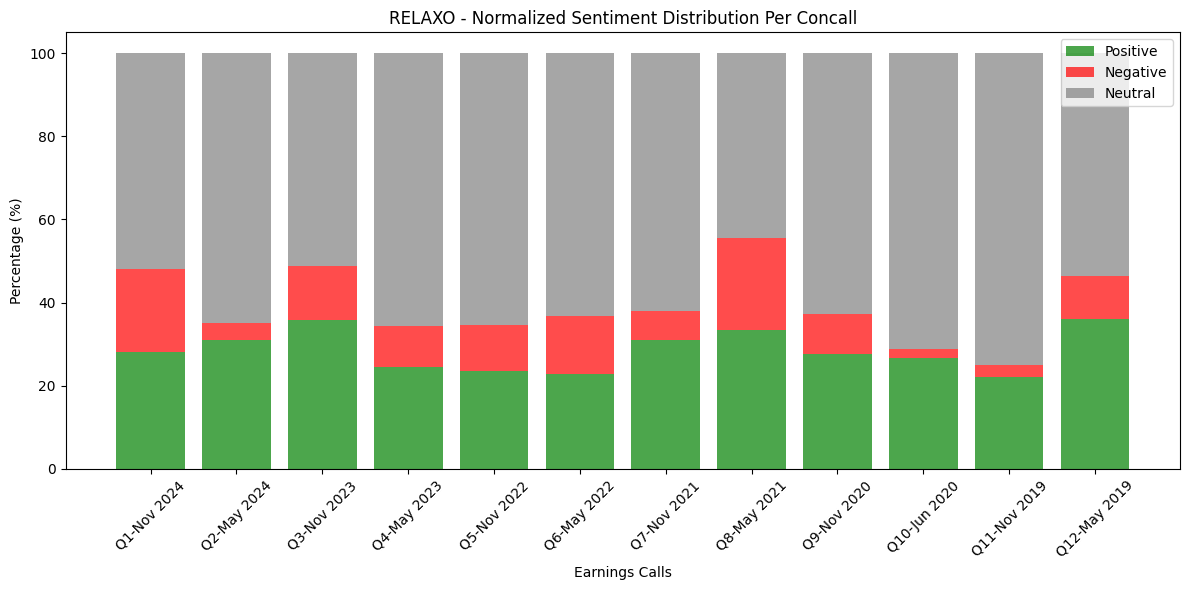

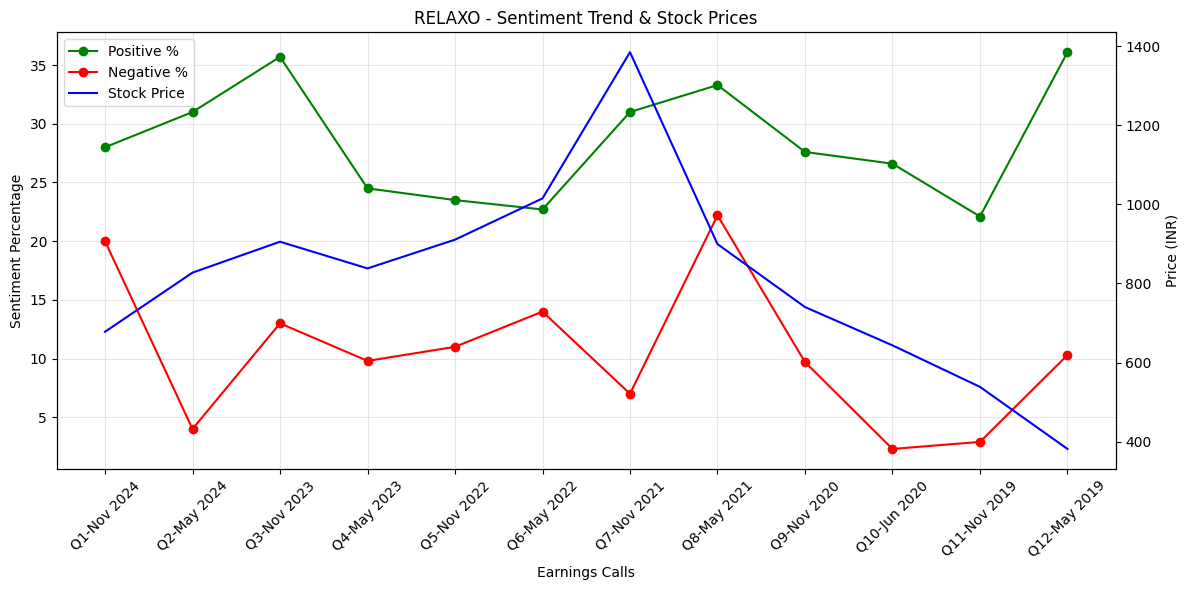


===== TOP POSITIVE COMMENTS FROM ANALYSTS/INVESTORS =====
1. Concall: concall_1, Speaker: Gaurav Kumaar Dua
   Text: I think company is taking a lot of steps to improve the margins. On the back-end front, we are working very closely with the manufacturing how to really improve our productivity and add on to our marg...
   Confidence: 1.0

2. Concall: concall_1, Speaker: Gaurav Kumaar Dua
   Text: Sparx, I think we are able to maintain the momentum in Sparx compared to the other open footwear. So I think Sparx should definitely be better off compared to other 2 brands, that is Flite and Bahamas...
   Confidence: 1.0

3. Concall: concall_1, Speaker: Gaurav Kumaar Dua
   Text: Currently, like in October or whatever, you can see the start, we have not seen a great start. So we are hoping that because of this November-December having a huge number of weddings, so demand shoul...
   Confidence: 1.0

4. Concall: concall_1, Speaker: Sameer Gupta
   Text: I noticed that there is an ASP increas

In [ ]:
#!pip install yfinance

import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from collections import defaultdict

def count_analyst_investor_sentiment(chunks_for_each_concall):
    """
    Count positive and negative comments by analysts/investors from pre-classified chunks
    """
    # Initialize counters for overall totals
    total_counts = {
        'analyst_investor': {'positive': 0, 'negative': 0, 'neutral': 0, 'total': 0},
        'company_official': {'positive': 0, 'negative': 0, 'neutral': 0, 'total': 0},
        'moderator': {'positive': 0, 'negative': 0, 'neutral': 0, 'total': 0},
        'unknown': {'positive': 0, 'negative': 0, 'neutral': 0, 'total': 0}
    }
    
    # Track sentiment by concall
    concall_sentiment = {}
    
    # Track highest confidence comments
    top_comments = {
        'positive': [],
        'negative': []
    }
    
    # Process each concall
    for concall_id, chunks in chunks_for_each_concall.items():
        print(f"Analyzing sentiments for: {concall_id}")
        
        # Initialize counters for this concall
        concall_counts = {
            'analyst_investor': {'positive': 0, 'negative': 0, 'neutral': 0, 'total': 0},
            'company_official': {'positive': 0, 'negative': 0, 'neutral': 0, 'total': 0},
            'moderator': {'positive': 0, 'negative': 0, 'neutral': 0, 'total': 0},
            'unknown': {'positive': 0, 'negative': 0, 'neutral': 0, 'total': 0}
        }
        
        # Process each chunk
        for chunk in chunks:
            # Skip if missing required fields
            if 'role' not in chunk or 'sentiment' not in chunk:
                continue
                
            # Determine role category
            role = chunk['role'].lower()
            if role in ['analyst', 'investor']:
                role_category = 'analyst_investor'
            elif role in ['company official', 'ceo', 'cfo', 'executive']:
                role_category = 'company_official'
            elif role in ['moderator']:
                role_category = 'moderator'
            else:
                role_category = 'unknown'
            
            # Get sentiment classification
            sentiment = chunk['sentiment']['classification']
            confidence = chunk['sentiment']['confidence']
            
            # Normalize sentiment label (in case of different formats)
            if sentiment.lower() in ['positive', 'pos']:
                sentiment_category = 'positive'
            elif sentiment.lower() in ['negative', 'neg']:
                sentiment_category = 'negative'
            else:
                sentiment_category = 'neutral'
                
            # Update counters
            concall_counts[role_category][sentiment_category] += 1
            concall_counts[role_category]['total'] += 1
            
            total_counts[role_category][sentiment_category] += 1
            total_counts[role_category]['total'] += 1
            
            # Track top comments from analysts/investors
            if role_category == 'analyst_investor' and confidence >= 0.7:
                if sentiment_category in ['positive', 'negative']:
                    top_comments[sentiment_category].append({
                        'concall': concall_id,
                        'speaker': chunk['speaker'],
                        'text': chunk['text'][:200] + '...' if len(chunk['text']) > 200 else chunk['text'],
                        'confidence': confidence
                    })
        
        # Store results for this concall
        concall_sentiment[concall_id] = concall_counts
    
    # Sort top comments by confidence
    for sentiment_type in top_comments:
        top_comments[sentiment_type] = sorted(
            top_comments[sentiment_type], 
            key=lambda x: x['confidence'], 
            reverse=True
        )[:5]  # Keep only top 5
    
    return {
        'total_counts': total_counts,
        'concall_sentiment': concall_sentiment,
        'top_comments': top_comments
    }

def generate_sentiment_report(sentiment_counts, companies):
    """
    Generate report and visualizations based on sentiment counts
    """
    total_counts = sentiment_counts['total_counts']
    concall_sentiment = sentiment_counts['concall_sentiment']
    top_comments = sentiment_counts['top_comments']
    
    # Print overall statistics
    print("\n===== ANALYST & INVESTOR SENTIMENT SUMMARY =====")
    ai_counts = total_counts['analyst_investor']
    print(f"Total Comments: {ai_counts['total']}")
    print(f"Positive: {ai_counts['positive']} ({round(ai_counts['positive']/ai_counts['total']*100, 1)}%)")
    print(f"Negative: {ai_counts['negative']} ({round(ai_counts['negative']/ai_counts['total']*100, 1)}%)")
    print(f"Neutral: {ai_counts['neutral']} ({round(ai_counts['neutral']/ai_counts['total']*100, 1)}%)")
    
    # Prepare data for trends analysis
    trend_data = {
        'concall_id': [],
        'positive': [],
        'negative': [],
        'neutral': [],
        'total': [],
        'pos_pct': [],
        'neg_pct': []
    }
    
    for concall_id, counts in concall_sentiment.items():
        ai_counts = counts['analyst_investor']
        if ai_counts['total'] > 0:  # Avoid division by zero
            trend_data['concall_id'].append(concall_id)
            trend_data['positive'].append(ai_counts['positive'])
            trend_data['negative'].append(ai_counts['negative'])
            trend_data['neutral'].append(ai_counts['neutral'])
            trend_data['total'].append(ai_counts['total'])
            trend_data['pos_pct'].append(round(ai_counts['positive']/ai_counts['total']*100, 1))
            trend_data['neg_pct'].append(round(ai_counts['negative']/ai_counts['total']*100, 1))
    
    # Create DataFrame for trends
    trend_df = pd.DataFrame(trend_data)
    trend_df['numeric_id'] = trend_df['concall_id'].str.extract(r'(\d+)').astype(int)  # Extract numeric part
    trend_df = trend_df.sort_values('numeric_id').drop(columns=['numeric_id'])  # Sort by numeric part and drop helper column
    
    print("\nSentiment Trends by Earnings Call:")
    print(trend_df.to_string(index=False))
    
    # Save to CSV
    trend_df.to_csv(f"{companies[0]}_analyst_investor_sentiment_trends.csv", index=False)
    
    # Create visualization
    plt.figure(figsize=(12, 6))
    x = ['Q1-Nov 2024', 'Q2-May 2024', 'Q3-Nov 2023', 'Q4-May 2023', 'Q5-Nov 2022', 'Q6-May 2022', 'Q7-Nov 2021', 'Q8-May 2021', 'Q9-Nov 2020', 'Q10-Jun 2020', 'Q11-Nov 2019', 'Q12-May 2019']

    # Define the stock ticker (e.g., RELAXO on NSE)
    ticker = "RELAXO.NS"

    # List of dates (YYYY-MM-DD format)
    dates = ["2024-11-14", "2024-05-14", "2023-11-08", "2023-05-08", "2022-11-15", "2022-05-17", "2021-11-15", "2021-05-17", "2020-11-17", "2020-06-15", "2019-11-15", "2019-05-15"]

    # Initialize an empty list to store average prices
    avg_prices = []

    for date in dates:
        # Fetch data for the specific date
        data = yf.download(
            ticker,
            start=date,
            end=(pd.to_datetime(date) + pd.Timedelta(days=1)).strftime('%Y-%m-%d'),
            progress=False
        )

        # Compute average closing price if data exists
        if not data.empty:
            avg_price = data['Close'].mean()
            avg_prices.append(avg_price)
        else:
            avg_prices.append(None)  # Append None if no data (market closed)

    # Create stacked bar chart
    # Define the height of all bars as 100 (normalized)
    bar_height = [100] * len(trend_df)

    plt.bar(x, trend_df['pos_pct'], label='Positive', color='green', alpha=0.7)
    plt.bar(x, trend_df['neg_pct'], bottom=trend_df['pos_pct'], 
            label='Negative', color='red', alpha=0.7)
    plt.bar(x, 100 - (trend_df['pos_pct'] + trend_df['neg_pct']), 
            bottom=trend_df['pos_pct'] + trend_df['neg_pct'], 
            label='Neutral', color='gray', alpha=0.7)

    # Aesthetics
    plt.xlabel("Earnings Calls")
    plt.ylabel("Percentage (%)")
    plt.title(f'{companies[0]} - Normalized Sentiment Distribution Per Concall')
    plt.xticks(x, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{companies[0]}_sentiment_distribution.png")
    
    # Create second chart for sentiment ratio trend
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Plot sentiment data (left y-axis)
    ax1.plot(x, trend_df['pos_pct'], 'go-', label='Positive %')
    ax1.plot(x, trend_df['neg_pct'], 'ro-', label='Negative %')
    ax1.set_xlabel('Earnings Calls')
    ax1.set_ylabel('Sentiment Percentage')
    ax1.set_title(f'{companies[0]} - Sentiment Trend & Stock Prices')
    ax1.set_xticks(x)
    ax1.set_xticklabels(x, rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # Create secondary axis for stock prices
    ax2 = ax1.twinx()
    
    # Plot stock price data (right y-axis)
    ax2.plot(x, avg_prices, 'b-', label='Stock Price')
    ax2.set_ylabel('Price (INR)')
    
    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    plt.tight_layout()
    plt.savefig(f"{companies[0]}_sentiment vs price trend.png")
    plt.show()
    
    # Display top comments
    print("\n===== TOP POSITIVE COMMENTS FROM ANALYSTS/INVESTORS =====")
    for i, comment in enumerate(top_comments['positive'], 1):
        print(f"{i}. Concall: {comment['concall']}, Speaker: {comment['speaker']}")
        print(f"   Text: {comment['text']}")
        print(f"   Confidence: {comment['confidence']}")
        print()
    
    print("\n===== TOP NEGATIVE COMMENTS FROM ANALYSTS/INVESTORS =====")
    for i, comment in enumerate(top_comments['negative'], 1):
        print(f"{i}. Concall: {comment['concall']}, Speaker: {comment['speaker']}")
        print(f"   Text: {comment['text']}")
        print(f"   Confidence: {comment['confidence']}")
        print()
    
    # Save detailed results to a text file
    with open(f"{companies[0]}_analyst_investor_sentiment_report.txt", 'w') as f:
        f.write("===== ANALYST & INVESTOR SENTIMENT ANALYSIS =====\n\n")
        
        # Write summary
        ai_counts = total_counts['analyst_investor']
        f.write("OVERALL STATISTICS\n")
        f.write(f"Total Comments: {ai_counts['total']}\n")
        f.write(f"Positive: {ai_counts['positive']} ({round(ai_counts['positive']/ai_counts['total']*100, 1)}%)\n")
        f.write(f"Negative: {ai_counts['negative']} ({round(ai_counts['negative']/ai_counts['total']*100, 1)}%)\n")
        f.write(f"Neutral: {ai_counts['neutral']} ({round(ai_counts['neutral']/ai_counts['total']*100, 1)}%)\n\n")
        
        # Write per-concall statistics
        f.write("SENTIMENT BY EARNINGS CALL\n")
        f.write(trend_df.to_string(index=False))
        f.write("\n\n")
        
        # Write sample comments
        f.write("TOP POSITIVE COMMENTS\n")
        for i, comment in enumerate(top_comments['positive'], 1):
            f.write(f"{i}. Concall: {comment['concall']}, Speaker: {comment['speaker']}\n")
            f.write(f"   Text: {comment['text']}\n")
            f.write(f"   Confidence: {comment['confidence']}\n\n")
        
        f.write("TOP NEGATIVE COMMENTS\n")
        for i, comment in enumerate(top_comments['negative'], 1):
            f.write(f"{i}. Concall: {comment['concall']}, Speaker: {comment['speaker']}\n")
            f.write(f"   Text: {comment['text']}\n")
            f.write(f"   Confidence: {comment['confidence']}\n\n")

    return trend_df

# Run the analysis with pre-classified chunks
print("Counting sentiments from pre-classified chunks...")
sentiment_counts = count_analyst_investor_sentiment(chunks_for_each_concall)

# Generate report and visualizations
trend_df = generate_sentiment_report(sentiment_counts, companies)

print(f"Analysis complete. Results saved to {companies[0]}_analyst_investor_sentiment_report.txt")

In [20]:
# Now assigning the final combined sentiment score for the entire transcript with higher priority to the sentiment of analysts.
import statistics
import numpy as np
def compute_overall_sentiment(chunks):
    """Compute overall sentiment based on all chunk sentiments."""
    # scores = [chunk["sentiment"]["confidence"] for chunk in chunks if "sentiment" in chunk]
    POSITIVE = 1
    NEGATIVE = -3
    NEUTRAL = 0
    Priority_Analyst = 2
    Priority_Investor = 2
    Priority_Company = 0
    Priority_Moderator = 0
    for chunk in chunks:
        if chunk["sentiment"]["classification"] == "POSITIVE":
            chunk["sentiment"]["confidence"] = POSITIVE * chunk["sentiment"]["confidence"]
        elif chunk["sentiment"]["classification"] == "NEGATIVE":
            chunk["sentiment"]["confidence"] = NEGATIVE * chunk["sentiment"]["confidence"]
        elif chunk["sentiment"]["classification"] == "NEUTRAL":
            chunk["sentiment"]["confidence"] = NEUTRAL * chunk["sentiment"]["confidence"]
    
    scores = 0
    for chunk in chunks:
        if chunk["role"] == "Analyst":
            scores += Priority_Analyst * chunk["sentiment"]["confidence"]
        elif chunk["role"] == "Investor":
            scores += Priority_Investor * chunk["sentiment"]["confidence"]
        elif chunk["role"] == "Moderator":
            scores += Priority_Moderator * chunk["sentiment"]["confidence"]
        else:
            scores += Priority_Company * chunk["sentiment"]["confidence"]
    
    if scores:
        avg_score = scores/(len(chunks)+1)
        overall_sentiment = (
            "Positive" if avg_score > 0.6 else
            "Negative" if avg_score < 0.5 else
            "Neutral"
        )
    else:
        overall_sentiment = "Neutral"
    return {
        "overall_sentiment": overall_sentiment,
        "average_score": round(avg_score, 3) if scores else None
    }
# Perform sentiment classification on extracted chunks
overall_sentiments = {}
for key, dialogues in chunks_for_each_concall.items():
    print(f"Classifying overall sentiment for: {key}")
    overall_sentiment = compute_overall_sentiment(dialogues)
    overall_sentiments[key] = overall_sentiment
    print(f"Overall Sentiment: {overall_sentiment['overall_sentiment']} (Average Score: {overall_sentiment['average_score']})")
# # Save the overall sentiments to a file
# with open(f"{companies[0]}_overall_sentiment.txt", 'w') as f:
#     for key, sentiment in overall_sentiments.items():
#         f.write(f"Concall: {key}\n")
#         f.write(f"Overall Sentiment: {sentiment['overall_sentiment']} (Average Score: {sentiment['average_score']})\n")
#         f.write("\n")

Classifying overall sentiment for: concall_1
Overall Sentiment: Positive (Average Score: 1.047)
Classifying overall sentiment for: concall_2
Overall Sentiment: Positive (Average Score: 1.2)
Classifying overall sentiment for: concall_3
Overall Sentiment: Positive (Average Score: 1.243)
Classifying overall sentiment for: concall_5
Overall Sentiment: Positive (Average Score: 1.314)
Classifying overall sentiment for: concall_6
Overall Sentiment: Positive (Average Score: 1.247)
Classifying overall sentiment for: concall_7
Overall Sentiment: Positive (Average Score: 1.378)
Classifying overall sentiment for: concall_8
Overall Sentiment: Positive (Average Score: 1.235)
Classifying overall sentiment for: concall_9
Overall Sentiment: Positive (Average Score: 1.003)
Classifying overall sentiment for: concall_10
Overall Sentiment: Positive (Average Score: 1.314)
Classifying overall sentiment for: concall_12
Overall Sentiment: Positive (Average Score: 1.217)
Classifying overall sentiment for: conca

In [21]:
from transformers import pipeline

# Load BloombergGPT (requires access to the model)
classifier = pipeline("text-classification", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

# text = "My question is about the 15% drop in margins this quarter. How do you justify this erosion given your earlier guidance?"
# text = "My first question was on the commentary that you made in the press release regarding consumers down-trading to lower price on organized competition and your call to not dilute prices. So how do you see that impacting volumes and market share in the near term?"
text = "Temporarily, we can say, yes. But in long term, I think we will be able to gain back the market share. It's because of 2 factors. There is poor footfalls, demand is also subdued and the raw material prices, all these things, because of multiple factors, they were able to enter. But I think now the wedding season, we are hearing like quarter 3, a lot of weddings are happening, there will be a demand uptake in the market and things will improve."
result = classifier(text)
print(result)  # Output: {'label': 'Negative', 'score': 0.89}

Device set to use cuda:0


[{'label': 'positive', 'score': 0.9996836185455322}]
